# Phase 2: Feature Engineering & Training Windows

This notebook:
1. **Loads data** from Phase 1 (with entry-based heatmaps)
2. **Engineers features** from existing FeaturesLibrary
3. **Creates sliding windows** for sequence modeling
4. **Prepares train/test splits** with proper time-series validation

Goal: Transform raw price data + heatmap labels into ML-ready sequences.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

warnings.filterwarnings('ignore')

# Add FEATURES directory to path for FeaturesLibrary
sys.path.append('../FEATURES')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Data from Phase 1

In [24]:
# Load the prepared dataset with entry-based heatmaps
df = pd.read_csv('../DATA/eurusd_with_heatmaps.csv', parse_dates=True, index_col='time')
events_df = pd.read_csv('../DATA/eurusd_barrier_events.csv', parse_dates=['entry_time', 'exit_time'])

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nTotal events: {len(events_df)}")
print(f"\nAvailable columns: {df.columns.tolist()}")

df.head()

Data shape: (13676, 37)
Date range: 2015-01-02 12:00:00 to 2023-09-20 08:00:00

Total events: 327

Available columns: ['open', 'high', 'low', 'close', 'tick_volume', 'low_time', 'high_time', 'ma_fast', 'ma_slow', 'signal', 'signal_shift', 'entry_long', 'entry_short', 'entry_signal', 'outcome_label', 'in_trade', 'trade_id', 'tp_heatmap', 'sl_heatmap', 'combined_heatmap', 'tp_prob', 'sl_prob', 'nohit_prob', 'tp_prob_raw', 'sl_prob_raw', 'signed_heatmap', 'tp_signed', 'sl_signed', 'heatmap_magnitude', 'heatmap_direction', 'tp_heatmap_only', 'sl_heatmap_only', 'tp_signed_entry', 'sl_signed_entry', 'signed_heatmap_entry', 'heatmap_magnitude_entry', 'heatmap_direction_entry']


,open,high,low,close,tick_volume,low_time,high_time,ma_fast,ma_slow,signal,signal_shift,entry_long,entry_short,entry_signal,outcome_label,in_trade,trade_id,tp_heatmap,sl_heatmap,combined_heatmap,tp_prob,sl_prob,nohit_prob,tp_prob_raw,sl_prob_raw,signed_heatmap,tp_signed,sl_signed,heatmap_magnitude,heatmap_direction,tp_heatmap_only,sl_heatmap_only,tp_signed_entry,sl_signed_entry,signed_heatmap_entry,heatmap_magnitude_entry,heatmap_direction_entry
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 12:00:00,1.20467,1.20600,1.20347,1.20377,14827,2015-01-02 15:36:00,2015-01-02 12:48:00,NaN,NaN,0,NaN,0,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
2015-01-02 16:00:00,1.20377,1.20437,1.20069,1.20131,19160,2015-01-02 19:36:00,2015-01-02 16:00:00,NaN,NaN,0,0.0,0,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
2015-01-02 20:00:00,1.20133,1.20154,1.20011,1.20029,9335,2015-01-02 23:12:00,2015-01-02 20:00:00,NaN,NaN,0,0.0,0,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
2015-01-03 00:00:00,1.20030,1.20055,1.19997,1.20014,1351,2015-01-03 00:24:00,2015-01-03 00:00:00,NaN,NaN,0,0.0,0,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
2015-01-05 00:00:00,1.19454,1.19755,1.18642,1.19624,13941,2015-01-05 00:48:00,2015-01-05 03:36:00,NaN,NaN,0,0.0,0,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0


## 2. Import Feature Engineering Functions

In [25]:
# Import existing feature engineering functions
try:
    from FeaturesLibrary import *
    print("✅ FeaturesLibrary imported successfully")
except ImportError as e:
    print(f"⚠️ Could not import FeaturesLibrary: {e}")
    print("We'll define basic features manually")

✅ FeaturesLibrary imported successfully


## 3. Feature Engineering

We'll create features from multiple categories:
- **Price features**: Returns, log returns, OHLC relationships
- **Volatility**: Parkinson, Yang-Zhang estimators
- **Technical**: RSI, ATR, Bollinger Bands
- **Statistical**: Rolling mean, std, skewness
- **Derivatives**: Velocity, acceleration of price
- **Market regime**: KAMA-based features

In [26]:
def add_basic_features(df, windows=[5, 10, 20, 50]):
    """
    Add basic technical features
    """
    df = df.copy()
    
    # Returns
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # OHLC features
    df['hl_spread'] = (df['high'] - df['low']) / df['close']
    df['co_spread'] = (df['close'] - df['open']) / df['open']
    
    # Rolling statistics
    for window in windows:
        df[f'returns_mean_{window}'] = df['returns'].rolling(window).mean()
        df[f'returns_std_{window}'] = df['returns'].rolling(window).std()
        df[f'close_std_{window}'] = df['close'].rolling(window).std()
        
        # Volume features (using tick_volume)
        if 'tick_volume' in df.columns:
            df[f'tick_volume_mean_{window}'] = df['tick_volume'].rolling(window).mean()
            df[f'tick_volume_std_{window}'] = df['tick_volume'].rolling(window).std()
        
        # RSI-like momentum
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / (loss + 1e-10)
        df[f'rsi_{window}'] = 100 - (100 / (1 + rs))
    
    return df

# Apply features
df = add_basic_features(df, windows=[5, 10, 20, 50])

print(f"After feature engineering: {df.shape}")
print(f"\nNew features created: {df.shape[1] - len(df.columns[:10])}")

# Show some features
feature_cols = [col for col in df.columns if col not in ['open', 'high', 'low', 'close', 'volume']]
print(f"\nFeature columns sample: {feature_cols[:15]}")

df[['close', 'returns', 'hl_spread', 'returns_std_20', 'rsi_20']].tail()

After feature engineering: (13676, 65)

New features created: 55

Feature columns sample: ['tick_volume', 'low_time', 'high_time', 'ma_fast', 'ma_slow', 'signal', 'signal_shift', 'entry_long', 'entry_short', 'entry_signal', 'outcome_label', 'in_trade', 'trade_id', 'tp_heatmap', 'sl_heatmap']


,close,returns,hl_spread,returns_std_20,rsi_20
time,,,,,
2023-09-19 16:00:00,1.06848,-0.001383,0.002143,0.001792,40.800296
2023-09-19 20:00:00,1.06790,-0.000543,0.001470,0.001336,50.509255
2023-09-20 00:00:00,1.06849,0.000552,0.000861,0.001183,59.400820
2023-09-20 04:00:00,1.06786,-0.000590,0.001068,0.001188,58.853628
2023-09-20 08:00:00,1.06964,0.001667,0.002262,0.001232,62.789592


## 4. Handle Missing Values

In [27]:
# Check for missing values
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

print("Missing values by column:")
missing_df = pd.DataFrame({'count': missing_counts, 'percentage': missing_pct})
missing_df = missing_df[missing_df['count'] > 0].sort_values('count', ascending=False)
print(missing_df.head(10))

# Drop initial rows with NaN (from rolling windows)
print(f"\nBefore dropping NaN: {len(df)} rows")
df_clean = df.dropna().copy()
print(f"After dropping NaN: {len(df_clean)} rows")
print(f"Rows dropped: {len(df) - len(df_clean)}")

Missing values by column:
                     count  percentage
returns_std_50          50    0.365604
returns_mean_50         50    0.365604
rsi_50                  49    0.358292
ma_slow                 49    0.358292
tick_volume_std_50      49    0.358292
tick_volume_mean_50     49    0.358292
close_std_50            49    0.358292
returns_std_20          20    0.146242
returns_mean_20         20    0.146242
rsi_20                  19    0.138930

Before dropping NaN: 13676 rows
After dropping NaN: 13626 rows
Rows dropped: 50


## 5. Feature Selection

Select relevant features for model training

In [28]:
# Define feature columns (exclude raw OHLCV, labels, and intermediate columns)
exclude_cols = [
    'open', 'high', 'low', 'close', 'volume', 'tick_volume',  # Raw OHLCV
    'low_time', 'high_time',  # Datetime columns
    'ma_fast', 'ma_slow', 'signal', 'signal_shift', 'entry_long', 'entry_short', 'entry_signal',  # Signal generation
    'outcome_label', 'in_trade', 'trade_id',  # Labels
    'tp_heatmap', 'sl_heatmap', 'combined_heatmap',  # Old exit-based heatmaps
    'tp_prob', 'sl_prob', 'nohit_prob', 'tp_prob_raw', 'sl_prob_raw',  # 3-class approach
    'signed_heatmap', 'tp_signed', 'sl_signed', 'heatmap_magnitude', 'heatmap_direction',  # Old exit-based
    'tp_heatmap_only', 'sl_heatmap_only',  # Intermediate
    'tp_signed_entry', 'sl_signed_entry', 'signed_heatmap_entry',  # Target columns
    'heatmap_magnitude_entry', 'heatmap_direction_entry'  # Alternative targets
]

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Total feature columns: {len(feature_cols)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# Create feature matrix
X = df_clean[feature_cols].copy()
y = df_clean['signed_heatmap_entry'].copy()

print(f"\nFeature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Min: {y.min():.4f}")
print(f"  Max: {y.max():.4f}")
print(f"  Mean: {y.mean():.4f}")
print(f"  Std: {y.std():.4f}")

Total feature columns: 28

Feature columns:
  1. returns
  2. log_returns
  3. hl_spread
  4. co_spread
  5. returns_mean_5
  6. returns_std_5
  7. close_std_5
  8. tick_volume_mean_5
  9. tick_volume_std_5
  10. rsi_5
  11. returns_mean_10
  12. returns_std_10
  13. close_std_10
  14. tick_volume_mean_10
  15. tick_volume_std_10
  16. rsi_10
  17. returns_mean_20
  18. returns_std_20
  19. close_std_20
  20. tick_volume_mean_20
  21. tick_volume_std_20
  22. rsi_20
  23. returns_mean_50
  24. returns_std_50
  25. close_std_50
  26. tick_volume_mean_50
  27. tick_volume_std_50
  28. rsi_50

Feature matrix X shape: (13626, 28)
Target vector y shape: (13626,)

Target distribution:
  Min: -1.0000
  Max: 1.0000
  Mean: -0.0317
  Std: 0.2858


## 6. Create Sliding Windows for Sequence Modeling

For LSTM/CNN models, we need sequences of past observations to predict the current outcome.

In [29]:
def create_sequences(X, y, window_length=60, stride=1):
    """
    Create sliding window sequences for time series modeling.
    
    Parameters:
    -----------
    X : DataFrame of features (n_samples, n_features)
    y : Series of targets (n_samples,)
    window_length : Number of past timesteps to include
    stride : Step size between consecutive windows
    
    Returns:
    --------
    X_seq : array (n_sequences, window_length, n_features)
    y_seq : array (n_sequences,)
    indices : array of end indices for each sequence
    """
    X_array = X.values
    y_array = y.values
    
    X_sequences = []
    y_sequences = []
    indices = []
    
    for i in range(window_length, len(X), stride):
        X_sequences.append(X_array[i-window_length:i])
        y_sequences.append(y_array[i])  # Predict current timestep
        indices.append(i)
    
    X_seq = np.array(X_sequences)
    y_seq = np.array(y_sequences)
    indices = np.array(indices)
    
    return X_seq, y_seq, indices

# Create sequences
window_length = 60  # 60 bars = 10 days at 4H timeframe
stride = 1  # No overlap reduction for maximum data

X_seq, y_seq, seq_indices = create_sequences(X, y, window_length=window_length, stride=stride)

print(f"Sequence shape: {X_seq.shape}")
print(f"  - Number of sequences: {X_seq.shape[0]:,}")
print(f"  - Window length: {X_seq.shape[1]} timesteps")
print(f"  - Number of features: {X_seq.shape[2]}")
print(f"\nTarget shape: {y_seq.shape}")
print(f"\nTarget distribution in sequences:")
print(f"  Min: {y_seq.min():.4f}")
print(f"  Max: {y_seq.max():.4f}")
print(f"  Mean: {y_seq.mean():.4f}")
print(f"  Std: {y_seq.std():.4f}")
print(f"\nNon-zero targets: {(np.abs(y_seq) > 0.1).sum():,} ({(np.abs(y_seq) > 0.1).sum()/len(y_seq):.1%})")

Sequence shape: (13566, 60, 28)
  - Number of sequences: 13,566
  - Window length: 60 timesteps
  - Number of features: 28

Target shape: (13566,)

Target distribution in sequences:
  Min: -1.0000
  Max: 1.0000
  Mean: -0.0320
  Std: 0.2863

Non-zero targets: 2,734 (20.2%)

  - Number of sequences: 13,566
  - Window length: 60 timesteps
  - Number of features: 28

Target shape: (13566,)

Target distribution in sequences:
  Min: -1.0000
  Max: 1.0000
  Mean: -0.0320
  Std: 0.2863

Non-zero targets: 2,734 (20.2%)


## 7. Train/Validation/Test Split

For time series, we use temporal split (no shuffling!):
- Train: First 70%
- Validation: Next 15%
- Test: Last 15%

In [30]:
# Temporal split
n_total = len(X_seq)
n_train = int(n_total * 0.70)
n_val = int(n_total * 0.15)
n_test = n_total - n_train - n_val

X_train = X_seq[:n_train]
y_train = y_seq[:n_train]

X_val = X_seq[n_train:n_train+n_val]
y_val = y_seq[n_train:n_train+n_val]

X_test = X_seq[n_train+n_val:]
y_test = y_seq[n_train+n_val:]

print("Data split:")
print(f"  Train: {X_train.shape[0]:,} sequences ({n_train/n_total:.1%})")
print(f"  Val:   {X_val.shape[0]:,} sequences ({n_val/n_total:.1%})")
print(f"  Test:  {X_test.shape[0]:,} sequences ({n_test/n_total:.1%})")

# Get corresponding dates
train_indices = seq_indices[:n_train]
val_indices = seq_indices[n_train:n_train+n_val]
test_indices = seq_indices[n_train+n_val:]

train_dates = df_clean.index[train_indices]
val_dates = df_clean.index[val_indices]
test_dates = df_clean.index[test_indices]

print(f"\nTemporal ranges:")
print(f"  Train: {train_dates[0]} to {train_dates[-1]}")
print(f"  Val:   {val_dates[0]} to {val_dates[-1]}")
print(f"  Test:  {test_dates[0]} to {test_dates[-1]}")

# Check target distribution in each split
print(f"\nTarget statistics by split:")
print(f"  Train - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}, Non-zero: {(np.abs(y_train)>0.1).sum()/len(y_train):.1%}")
print(f"  Val   - Mean: {y_val.mean():.4f}, Std: {y_val.std():.4f}, Non-zero: {(np.abs(y_val)>0.1).sum()/len(y_val):.1%}")
print(f"  Test  - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}, Non-zero: {(np.abs(y_test)>0.1).sum()/len(y_test):.1%}")

Data split:
  Train: 9,496 sequences (70.0%)
  Val:   2,034 sequences (15.0%)
  Test:  2,036 sequences (15.0%)

Temporal ranges:
  Train: 2015-01-28 04:00:00 to 2021-02-11 00:00:00
  Val:   2021-02-11 04:00:00 to 2022-06-01 00:00:00
  Test:  2022-06-01 04:00:00 to 2023-09-20 08:00:00

Target statistics by split:
  Train - Mean: -0.0226, Std: 0.2842, Non-zero: 19.9%
  Val   - Mean: -0.0582, Std: 0.2822, Non-zero: 19.9%
  Test  - Mean: -0.0498, Std: 0.2973, Non-zero: 21.9%


## 8. Feature Normalization

Normalize features using statistics from training set only (avoid lookahead bias)

In [31]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data only
# Reshape to 2D for scaler
n_train_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

X_train_2d = X_train.reshape(-1, n_features)
X_val_2d = X_val.reshape(-1, n_features)
X_test_2d = X_test.reshape(-1, n_features)

# Fit on training data
scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
X_test_scaled_2d = scaler.transform(X_test_2d)

# Reshape back to 3D
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape[0], n_timesteps, n_features)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape[0], n_timesteps, n_features)

print("✅ Feature normalization complete")
print(f"\nScaled train set stats:")
print(f"  Mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"  Std:  {X_train_scaled.std():.6f} (should be ~1)")
print(f"\nScaled val set stats:")
print(f"  Mean: {X_val_scaled.mean():.6f}")
print(f"  Std:  {X_val_scaled.std():.6f}")
print(f"\nScaled test set stats:")
print(f"  Mean: {X_test_scaled.mean():.6f}")
print(f"  Std:  {X_test_scaled.std():.6f}")

✅ Feature normalization complete

Scaled train set stats:
  Mean: 0.000000 (should be ~0)
  Std:  1.000000 (should be ~1)

Scaled val set stats:
  Mean: -0.397183
  Std:  0.811169

Scaled test set stats:
  Mean: -0.108883
  Std:  1.005412


## 9. Visualize Target Distribution

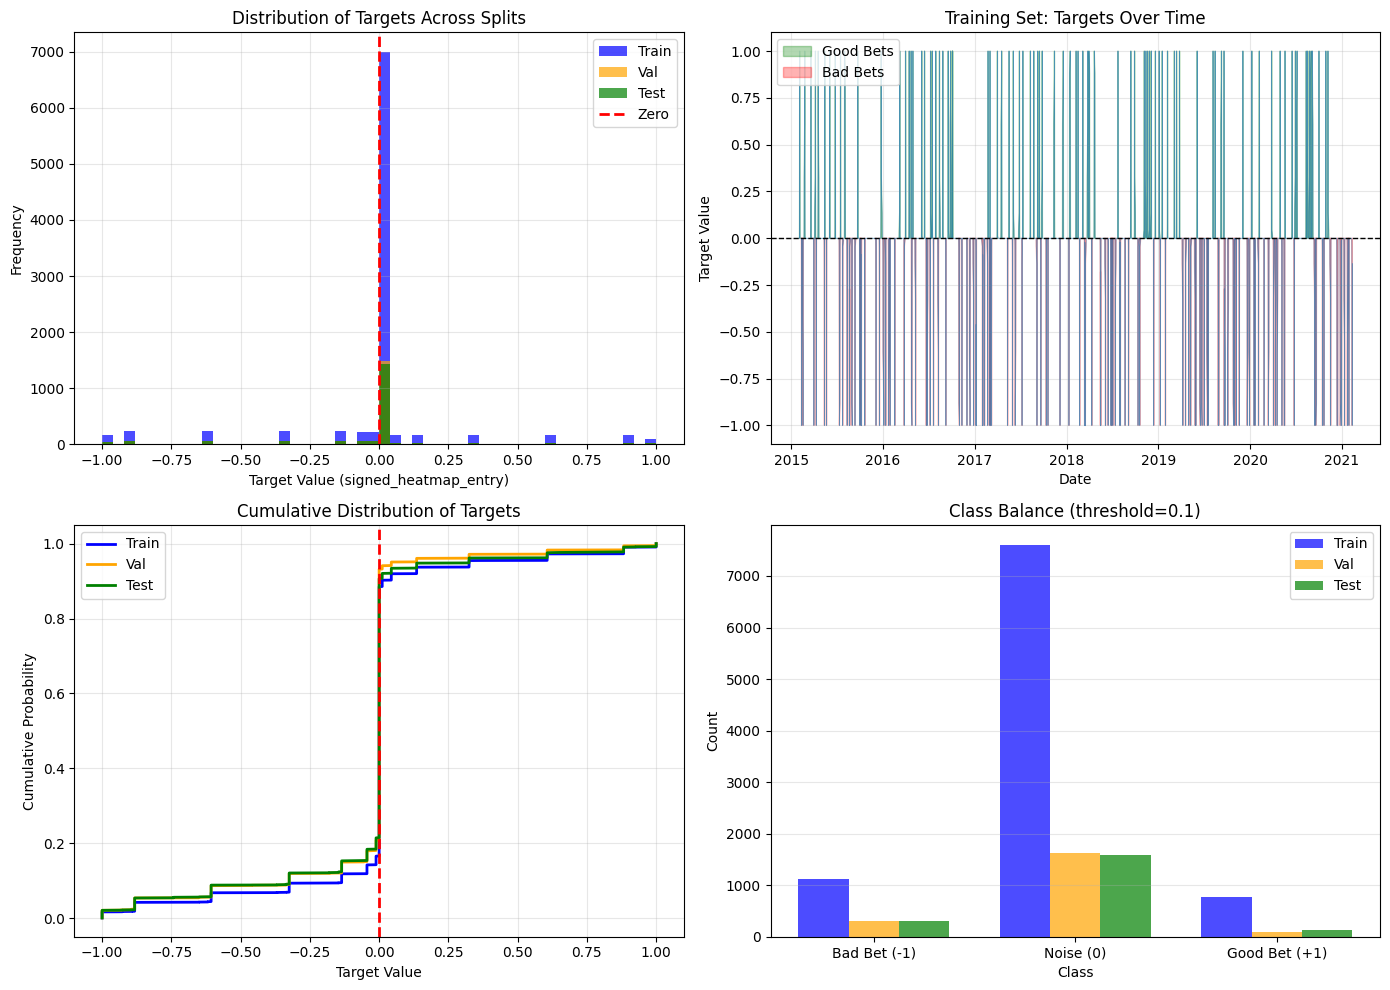


CLASS BALANCE (threshold=0.1):
Train: Bad=1,121 (11.8%), Noise=7,611 (80.1%), Good=764 (8.0%)
Val:   Bad=304 (14.9%), Noise=1,630 (80.1%), Good=100 (4.9%)
Test:  Bad=311 (15.3%), Noise=1,591 (78.1%), Good=134 (6.6%)


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram of targets
axes[0, 0].hist(y_train, bins=50, alpha=0.7, label='Train', color='blue')
axes[0, 0].hist(y_val, bins=50, alpha=0.7, label='Val', color='orange')
axes[0, 0].hist(y_test, bins=50, alpha=0.7, label='Test', color='green')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0, 0].set_xlabel('Target Value (signed_heatmap_entry)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Targets Across Splits')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Time series of targets (training set)
axes[0, 1].plot(train_dates, y_train, linewidth=0.5, alpha=0.7)
axes[0, 1].fill_between(train_dates, 0, y_train, where=(y_train > 0), color='green', alpha=0.3, label='Good Bets')
axes[0, 1].fill_between(train_dates, 0, y_train, where=(y_train < 0), color='red', alpha=0.3, label='Bad Bets')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Target Value')
axes[0, 1].set_title('Training Set: Targets Over Time')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Cumulative distribution
for y_split, label, color in [(y_train, 'Train', 'blue'), (y_val, 'Val', 'orange'), (y_test, 'Test', 'green')]:
    sorted_y = np.sort(y_split)
    cumulative = np.arange(1, len(sorted_y) + 1) / len(sorted_y)
    axes[1, 0].plot(sorted_y, cumulative, label=label, color=color, linewidth=2)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Target Value')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].set_title('Cumulative Distribution of Targets')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Class balance (discretized)
def discretize_targets(y, threshold=0.1):
    discrete = np.zeros_like(y)
    discrete[y > threshold] = 1  # Good bets
    discrete[y < -threshold] = -1  # Bad bets
    return discrete

y_train_discrete = discretize_targets(y_train)
y_val_discrete = discretize_targets(y_val)
y_test_discrete = discretize_targets(y_test)

labels = ['Bad Bet (-1)', 'Noise (0)', 'Good Bet (+1)']
train_counts = [(y_train_discrete == i).sum() for i in [-1, 0, 1]]
val_counts = [(y_val_discrete == i).sum() for i in [-1, 0, 1]]
test_counts = [(y_test_discrete == i).sum() for i in [-1, 0, 1]]

x = np.arange(len(labels))
width = 0.25

axes[1, 1].bar(x - width, train_counts, width, label='Train', color='blue', alpha=0.7)
axes[1, 1].bar(x, val_counts, width, label='Val', color='orange', alpha=0.7)
axes[1, 1].bar(x + width, test_counts, width, label='Test', color='green', alpha=0.7)
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Class Balance (threshold=0.1)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CLASS BALANCE (threshold=0.1):")
print("="*70)
print(f"Train: Bad={train_counts[0]:,} ({train_counts[0]/len(y_train):.1%}), "
      f"Noise={train_counts[1]:,} ({train_counts[1]/len(y_train):.1%}), "
      f"Good={train_counts[2]:,} ({train_counts[2]/len(y_train):.1%})")
print(f"Val:   Bad={val_counts[0]:,} ({val_counts[0]/len(y_val):.1%}), "
      f"Noise={val_counts[1]:,} ({val_counts[1]/len(y_val):.1%}), "
      f"Good={val_counts[2]:,} ({val_counts[2]/len(y_val):.1%})")
print(f"Test:  Bad={test_counts[0]:,} ({test_counts[0]/len(y_test):.1%}), "
      f"Noise={test_counts[1]:,} ({test_counts[1]/len(y_test):.1%}), "
      f"Good={test_counts[2]:,} ({test_counts[2]/len(y_test):.1%})")
print("="*70)

## 10. Save Processed Data

In [ ]:
# Save processed arrays
np.save('../DATA/X_train_scaled.npy', X_train_scaled)
np.save('../DATA/X_val_scaled.npy', X_val_scaled)
np.save('../DATA/X_test_scaled.npy', X_test_scaled)

np.save('../DATA/y_train.npy', y_train)
np.save('../DATA/y_val.npy', y_val)
np.save('../DATA/y_test.npy', y_test)

# Save scaler for future use
import joblib
joblib.dump(scaler, '../DATA/feature_scaler.pkl')

# Save metadata
metadata = {
    'window_length': window_length,
    'stride': stride,
    'n_features': n_features,
    'feature_names': feature_cols,
    'n_train': len(X_train),
    'n_val': len(X_val),
    'n_test': len(X_test),
    'train_date_range': (str(train_dates[0]), str(train_dates[-1])),
    'val_date_range': (str(val_dates[0]), str(val_dates[-1])),
    'test_date_range': (str(test_dates[0]), str(test_dates[-1]))
}

import json
with open('../DATA/data_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ All data saved successfully!")
print("\nSaved files:")
print("  - X_train_scaled.npy, X_val_scaled.npy, X_test_scaled.npy")
print("  - y_train.npy, y_val.npy, y_test.npy")
print("  - feature_scaler.pkl")
print("  - data_metadata.json") 

✅ All data saved successfully!

Saved files:
  - X_train_scaled.npy, X_val_scaled.npy, X_test_scaled.npy
  - y_train.npy, y_val.npy, y_test.npy
  - feature_scaler.pkl
  - data_metadata.json


## 🎯 Phase 2 Complete!

### What we accomplished:
1. ✅ Loaded data from Phase 1 with entry-based heatmaps
2. ✅ Engineered technical features (returns, volatility, RSI, etc.)
3. ✅ Created sliding window sequences (60 timesteps)
4. ✅ Split data temporally (70/15/15 train/val/test)
5. ✅ Normalized features using training set statistics
6. ✅ Saved processed data for model training

### Data ready for Phase 3:
- **X_train**: Shape `(n_train, 60, n_features)` - normalized feature sequences
- **y_train**: Shape `(n_train,)` - entry-based heatmap labels [-1, +1]
- **Class balance**: ~72% noise, ~18% bad bets, ~10% good bets

### Next Steps (Phase 3):
- Build dual-branch LSTM/CNN model
- Branch 1: Entry signal confidence
- Branch 2: Outcome prediction (heatmap)
- Combined architecture for meta-labeling